# Clasificación de uso de suelo utilizando imágenes del satélite Sentinel-2

Proyecto final de Aprendizaje Automático

Alumno: Erick Gabriel Fajardo Martínez\
Profesor: Luis Guillermo Ruiz Velázquez

## Descripción de los datos

Los datos provienen de EuroSAT, el cual es un conjunto de imágenes tomadas por el satélite Sentinel-2. Estas imágenes están conformadas por 10 clases que corresponden a los siguientes usos de suelo: 
- Bosque
- Autopista
- Industrial
- Cosecha anual
- Cosecha permanente
- Vegetación
- Residencial
- Mar/Lago
- Río
- Prado

Cada imagen tiene una dimensión de 64 $\times$ 64 píxeles $\times$ 3 canales (RGB). Este conjunto de imágenes no incluye las otras 10 bandas espectrales de Sentinel-2.

Este trabajo está dividido en 4 partes:

1. Cargado y preprocesado de las imágenes
2. Creación de los conjuntos de entrenamiento, validación y prueba.
3. Definición de la arquitectura y entrenamiento de la Red Neuronal Convolucional (RNC).
4. Evaluación de la RNC.

Cada sección incluye el código y comentarios sobre el funcionamiento del mismo, así como descripciones del procedimiento.


In [ ]:
# Cargar imágenes
from glob import glob
from os import listdir, path
from skimage.io import imread

# Preprocesamiento
import albumentations as A
from random import choice
import numpy as np

# Entrenamiento, validación, prueba
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Red Neuronal
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras import optimizers

# Evaluación
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
X_raw = np.load("/content/drive/MyDrive/training/X_landcover.npy")
Y_raw = np.load("/content/drive/MyDrive/training/Y_landcover.npy")

## Cargar datos y preprocesar

El conjunto completo consta de 21700 imágenes, sin embargo, el entrenamiento era excesivamente lento al utilizar todas las imágenes, por lo tanto, se decidió cargar únicamente 5000 imágenes (500 por cada categoría). 

Al momento de cargar las imágenes se hizo una parte del preprocesamiento, el cual consiste en transformaciones simples como rotaciones. Después, también se normalizaron las imágenes para que los valores de sus píxeles quedaran entre 0 y 1. 

Por último, se mezclaron las imágenes y las etiquetas de manera aleatoria para evitar que muchas imágenes del mismo tipo quedaran juntas.

In [ ]:
# Cargar imágenes

# Obtener nombre de las carpetas de cada clase
dir_imgs = listdir("/content/drive/MyDrive/EuroSAT")
dir_imgs = dir_imgs[4:]
dir_imgs

# Crear diccionario de etiquetas
label_dicc = {}
code = 0
for label in dir_imgs:
    label_dicc[label] = code
    code += 1

# Opciones de preprocesado
transform = A.Compose([
    A.HorizontalFlip(0.5),
    A.Flip(0.5),
    A.Transpose(0.5),
    A.RandomRotate90(0.5)
])

# Cargar primeras 500 imágenes por carpeta
X = []
Y = []
for label in dir_imgs:
    print(label)
    img_paths = glob("/content/drive/MyDrive/EuroSAT/" + label + "/*.jpg")
    img_paths
    for image in img_paths[0:500]:
        if choice([0, 1]) == 1:
            image_array = transform(image = imread(image))["image"]
            X.append(image_array)
            Y.append(label_dicc[label])
        else:
            image_array = imread(image)
            X.append(image_array)
            Y.append(label_dicc[label])

print("X", np.array(X).shape)
print("Y", np.array(Y).shape)


In [ ]:
X_raw = np.array(X)
Y_raw = np.array(Y).reshape(X_raw.shape[0], 1)

print("X_raw", X_raw.shape)
print("Y_raw", Y_raw.shape)

In [ ]:
# Guardar conjuntos de datos
if path.exists("/content/drive/MyDrive/training/X_landcover.npy") == False:
    np.save("/content/drive/MyDrive/training/X_landcover.npy", X_raw)
    np.save("/content/drive/MyDrive/training/Y_landcover.npy", Y_raw)

In [ ]:
# Convertir Y_raw a categórica
Y_cat = to_categorical(Y_raw)
Y_cat.shape

In [ ]:
# Mezclar X y Y
shuffler = np.random.permutation(len(X))
X_raw = X_raw[shuffler]
Y_cat = Y_cat[shuffler]

In [ ]:
# Mostrar algunas imágenes 
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 12))
for i, ax in zip(range(0, 5000, 500), axs.ravel()):
    ax.imshow(X[i])
    title_lab = [lab for lab in label_dicc if label_dicc[lab] == Y[i]][0]
    ax.set_title(title_lab)
    ax.axis("off")

plt.show()


In [ ]:
# Normalizar
def normalize_images(images):
    # array de 0s
    normalized_images = np.zeros_like(images.astype(float))

    num_images = images.shape[0]

    # Valores máximos y mínimos de la imagen
    maximum_value, minimum_value = images.max(), images.min()

    # Normalizar píxeles entre 0 y 1
    for img in range(num_images):
        normalized_images[img, ...] = (images[img, ...] - float(minimum_value)) / float(maximum_value - minimum_value)

    return normalized_images

In [ ]:
X_norm = normalize_images(X_raw)

## Train, validation y test sets

El conjunto de entrenamiento está conformado por 4000 imágenes, pero 800 imágenes (20%) se destinaron para formar el conjunto de validación, mientras que el conjunto de prueba contiene 1000 imágenes (20% del total de imágenes).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, Y_cat, test_size = 0.2, random_state = 13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 13)

In [ ]:
# Shapes
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

## CNN arquitectura

La arquitectura básica de la red neuronal está compuesta por 3 capas de convolución que utilizan la función de activación ReLU y todas contienen una capa de Max Pooling, una capa completamente conectada y la capa de salida que utiliza la función Softmax. 

Para refinar la arquitectura, se entrenó con un batch size de 32, durante 50 epochs y un learning rate variable que inicia en 0.001, pasa a 0.0001 y termina en 0.00001. Al obtener los primeros resultados, se procedió a probar agregando una capa de Batch Normalization, la cual provocó bastante overfitting, sin embargo, para corregir esto la última prueba para ajustar los hiper parámetros fue agregando capas de Dropout. Esto último logró aumentar el accuracy y mantenerlo estable en 80% (al inicio no alcanzaba el 80%).

Las siguientes imágenes muestran los resultados de las primeras pruebas que no incluían técnicas de regularización.

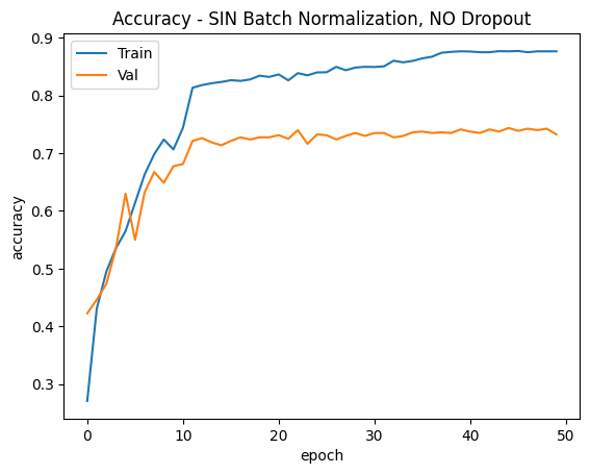

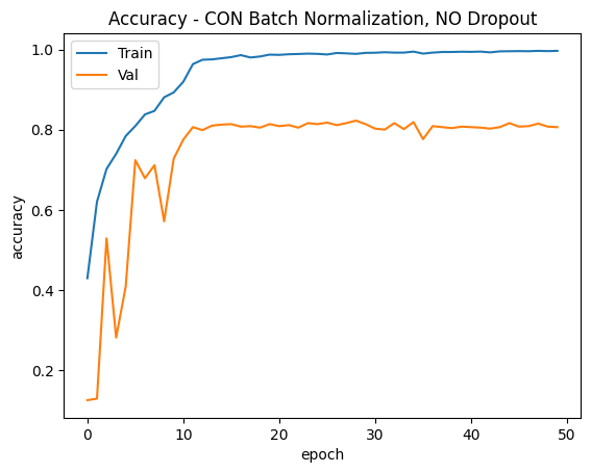

In [ ]:
model  =  Sequential()

# 1st Conv
model.add(Conv2D(32, (3, 3), strides = (1, 1), input_shape = (64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

# 2nd Conv
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

# 3rd Conv
model.add(Conv2D(128, (2, 2), activation = 'relu'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.4))

# Fully connected
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation = 'softmax'))

model.summary()

In [ ]:
def scheduler(epoch, lr):
    l = 0.001
    if epoch > 20:
        l = 0.0001
    if epoch > 70:
        l = 0.00001
    return l

callback = LearningRateScheduler(scheduler, verbose = 1)

In [ ]:
optim = optimizers.Adam()

In [ ]:
model.compile(loss = "categorical_crossentropy",
              optimizer = optim,
              metrics = ["acc"])

In [ ]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 100,
                    batch_size = 32,
                    callbacks = [callback])

## Evaluación - Fine tuning

In [ ]:
# Gráfico de accuracy por epoch en validación y entrenamiento
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy - CON Batch Normalization, CON Dropout')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


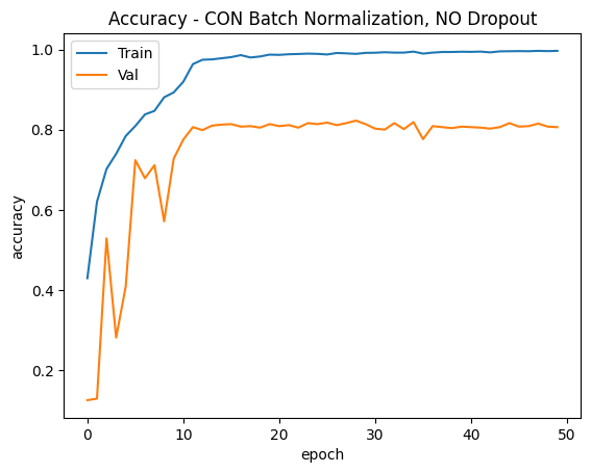

## Evaluación con el conjunto de prueba

Emplear las técnicas de regularización Batch Normalization y Dropout mejoró significativamente el desempeño de la red neuronal. Los resultados podrían mejorar si se empleara una red más profunda y se realizaran más pruebas para encontrar mejores hiperparámetros.

In [ ]:
results = model.evaluate(X_test, y_test)
print("test_loss, test_acc:", results)

In [ ]:
# See predictions by class
model_pred = model.predict(X_test, batch_size = 32)

print(classification_report(y_test, np.rint(model_pred)))